In [1]:
# preprocessing steps
# Resize images to 224x224
# Standardize the images from 0-1 by scaling with 255
# Split dataset into 24000 train images and 2684 validation images
# Store converted imahes in folders correspindiing to the class 0: no pnemonia, 1: pnemonia
# Compute the mean and standard deviation of the training dataset

# Apply data augmentation to the training dataset
# Randomly flip images horizontally
# Randomly rotate images
# Randomly zoom images
# Randomly shift images horizontally and vertically


# Training:
# Network: ResNet18
## Change input channels from 3 to 1
## change output dimension from 1000 to 1
# Loss: BCEWithLogitsLoss ## Binary Cross Entropy Loss directly applied to logits
## negative output values are converted to 0: no pneumonia, positive values are converted to 1: pneumonia
# Optimizer: Adam(lr=0.0001)
# EPochs: 30

# Interpretability:
# Compute Class activation maps for the images in the validation dataset
# store the last convolutional layer output for the images in the validation dataset known as the feature maps
# extract weights of the last layer
# compute the class activation map for each image
# overlay the class activation map on the original image to visualize the regions of interest
## Note: Only works with CNN
### Alternative GradCAM, GradCAM++, ScoreCAM #! May use these in the future to compare results

In [27]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import itertools

## Get Data from Kaggle: https://www.kaggle.com/competitions/rsna-pneumonia-detection-challenge/data
## Unzip data to the DATA directory

# Preprocess

In [2]:
labels = pd.read_csv('../DATA/x_ray_data/stage_2_train_labels.csv')
labels.head(10)

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
6  00569f44-917d-4c86-a842-81832af98c30    NaN    NaN    NaN     NaN       0
7  006cec2e-6ce2-4549-bffa-eadfcd1e9970    NaN    NaN    NaN     NaN       0
8  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1

In [3]:
# Drop deuplicates
labels = labels.drop_duplicates(subset=['patientId'])

In [ ]:
# Set root and save path where x ray images are stored and will be processed for training
ROOT_PATH = Path('../DATA/x_ray_data/stage_2_train_images/')
SAVE_PATH = Path('../DATA/x_ray_data/Processed')

In [16]:
labels.iloc[4].Target

np.int64(1)

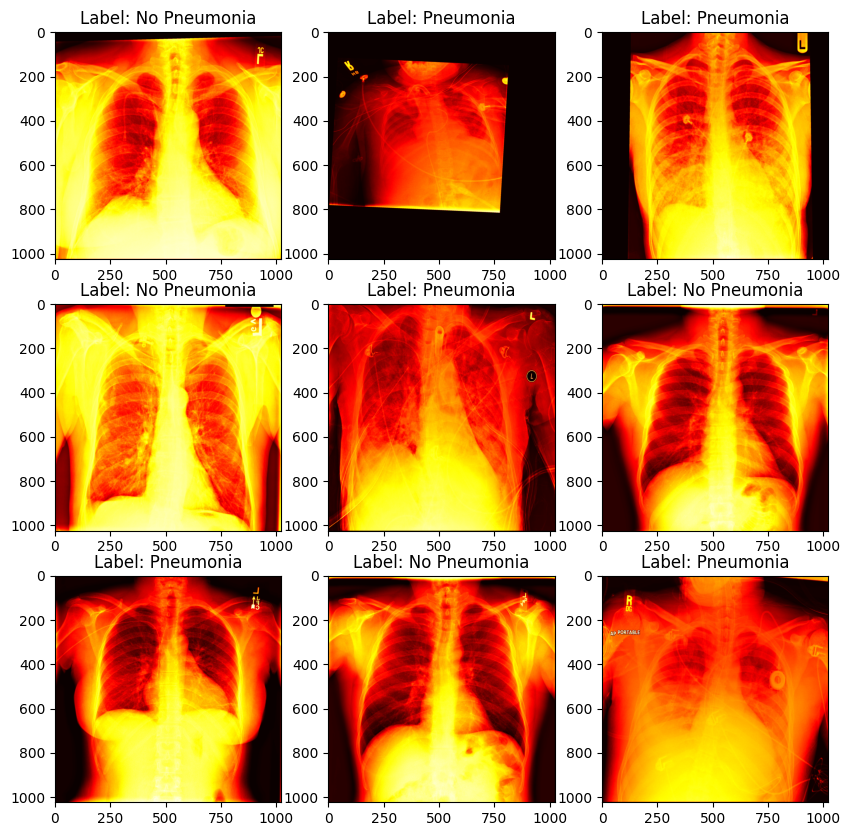

In [ ]:
# Visualize training images
fig, axis = plt.subplots(3, 3, figsize=(10, 10))
c = 11  # Counter, change to plot set of training x-ray images

for i,j in itertools.product(range(3), range(3)):
        img = pydicom.dcmread(ROOT_PATH / f'{labels.iloc[c].patientId}.dcm').pixel_array
        axis[i, j].imshow(img, cmap='hot')
        axis[i, j].axis('on')
        if labels.iloc[c].Target == 1:
            axis[i, j].set_title('Label: Pneumonia')
        else:
            axis[i, j].set_title('Label: No Pneumonia')
        c += 1


#TODO plt.colorbar(cbar, )
plt.savefig('F:/coding_projects/udemy_deep_learning_with_pytorch_medical_image_analysis/xray_pneumonia_classification/Visualizations/raw_training_images.jpeg', dpi=300)
plt.show()

## Compute the sum and sum squared for classification model
### Goal: to compute the training mean and standard deviation for normalization
### Challenge: Can compute and store the mean and standard deviation for each image in a large dataset
### ML trick to address challenge: Compute sum and sum squared of each image and then add those values to the global variable sums and sums_squared
### Equations

Sum: 
$$ \sum{X} = \sum_{i=1}^{N} \frac{Proceesed\_dcm\_array_i}{224 \times 224} $$

Sum of squares:
$$ \sum{X}^{2} = \sum_{i=1}^{N} \left(\frac{Processed\_dcm\_array_i}{224 \times 224}\right)^2 $$

Mean:
$$ \mu = \frac{\sum{X}}{24000} $$

Standard Deviation:
$$ \text{std} = \sqrt{\frac{\sum{X}^{2}}{24000} - \mu^2} $$

### Where 
#### Proceesed_dcm_images are the resized and standardized x-ray images
#### 224x224 is the normalizer
#### 24000 the number of training images - 24001 -> are validation data


In [32]:
sum, sums_squared = 0, 0
for c, patient_id in enumerate(tqdm(labels.patientId)):
    patient_id = labels.iloc[c].patientId
    dcm_path = ROOT_PATH / f'{patient_id}.dcm'
    dcm = pydicom.dcmread(dcm_path).pixel_array / 255 # Standardize the images

    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16) # Resize the images to 224x224

    label = labels.iloc[c].Target # Get the label for the image

    train_or_val = "train" if c < 24000 else "val"
    current_save_path = SAVE_PATH / train_or_val / str(label)
    current_save_path.mkdir(parents=True, exist_ok=True)

    np.save(current_save_path / patient_id, dcm_array)

    normalizer = 224*224
    if train_or_val == "train":
        sum += dcm_array.sum() / normalizer
        sums_squared += (dcm_array**2).sum() / normalizer


  0%|          | 0/26684 [00:00<?, ?it/s]

In [36]:
mean = sum / 24000
std = np.sqrt((sums_squared / 24000) - mean**2)
print(f'Mean: {mean}, Std: {std}')

Mean: 0.0853271484375, Std: 0.2340087890625


# Data Augmentation and Loading

In [3]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [4]:
def load_file(file_path):
    return np.load(file_path).astype(np.float32)

## Randomly transform the data the training data to make model more robust to classify chest X-ray

In [ ]:
train_transforms = transforms.Compose([
    transforms.ToTensor(), # Convert pixels values from 0-255 to 0-1
    transforms.Normalize(mean=0.085, std=0.234), # From the sums and sums_squared computed earlier
    transforms.RandomAffine(degrees=(-5,5), translate=(0,0.05), scale=(0.9,1.1)), # Randomly flips image within a range of degrees, shifts image within a range of pixels, scales image within a range of values
    transforms.RandomResizedCrop((224, 224), scale=(0.35, 1.)) # Randomly crops and resizes the image to desired image shape
    ])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.085, std=0.234) # From the sums and sums_squared computed earlier
])

## Load dataset

In [6]:
train_dataset = torchvision.datasets.DatasetFolder('../DATA/x_ray_data/Processed/train', extensions='.npy', transform=train_transforms, loader=load_file)
val_dataset = torchvision.datasets.DatasetFolder('../DATA/x_ray_data/Processed/val', extensions='.npy', transform=val_transforms, loader=load_file)

In [7]:
train_dataset

Dataset DatasetFolder
    Number of datapoints: 24000
    Root location: ../DATA/x_ray_data/Processed/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.085, std=0.234)
               RandomAffine(degrees=[-5.0, 5.0], translate=(0, 0.05), scale=(0.9, 1.1))
               RandomResizedCrop(size=(224, 224), scale=(0.35, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
           )

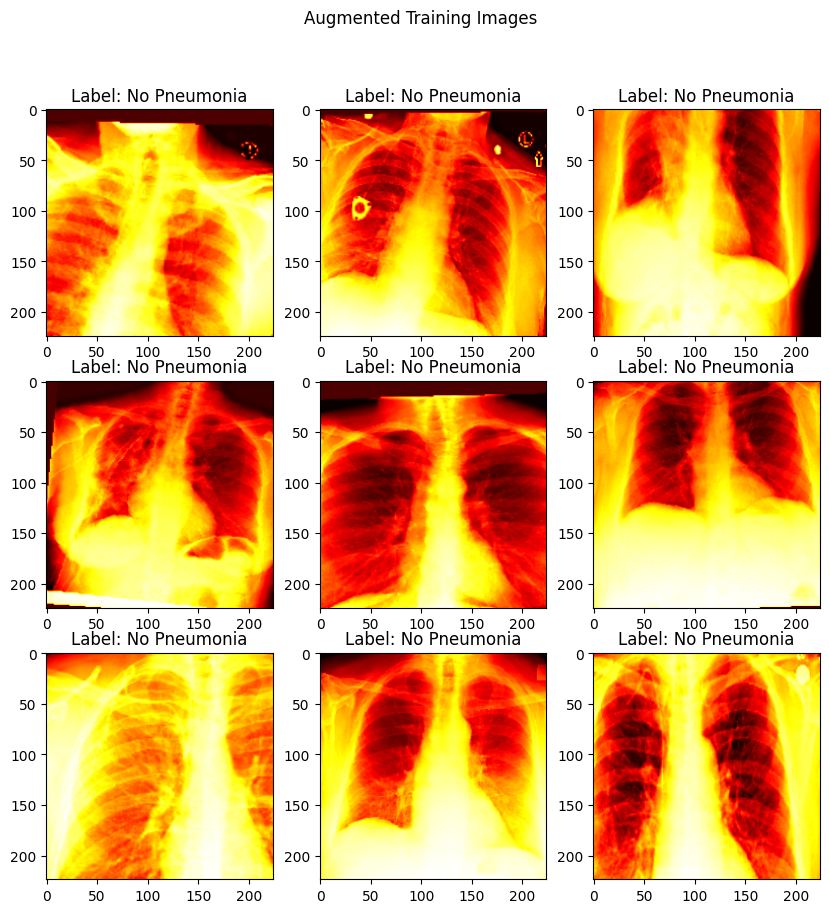

In [8]:
fig, axis = plt.subplots(3, 3, figsize=(10, 10))
plt.suptitle('Augmented Training Images')
for i, j in itertools.product(range(3), range(3)):
        random_index = np.random.randint(0, len(train_dataset))
        x_ray, label = train_dataset[random_index]
        axis[i, j].imshow(x_ray[0], cmap='hot')
        axis[i, j].set_title('Label: Pneumonia' if label == 1 else 'Label: No Pneumonia')
plt.savefig('F:/coding_projects/udemy_deep_learning_with_pytorch_medical_image_analysis/xray_pneumonia_classification/Visualizations/augmented_training_images.jpeg', dpi=300)
plt.show()

## Create Dataloaders

In [9]:
import os
import psutil

num_cores = os.cpu_count()
print(f'Number of CPU cores: {num_cores}')

# Get the amount of memory
virtual_memory = psutil.virtual_memory()
total_memory_gb = virtual_memory.total / (1024 ** 3)
available_memory_gb = virtual_memory.available / (1024 ** 3)

print(f'Total memory: {total_memory_gb:.2f} GB')
print(f'Available memory: {available_memory_gb:.2f} GB')

Number of CPU cores: 24
Total memory: 31.82 GB
Available memory: 16.67 GB


In [11]:
batch_size = 64
num_workers = 0 # put to 0 if you have memory issues may work better outside jupyter notebook

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [12]:
# Check if the data loader is working if not this will hang
for batch in train_loader:
    print("Batch loaded successfully!")
    break

Batch loaded successfully!


In [13]:
np.unique(train_dataset.targets, return_counts=True), np.unique(val_dataset.targets, return_counts=True)

((array([0, 1]), array([18593,  5407])), (array([0, 1]), array([2079,  605])))

## Build Model

In [14]:
torchvision.models.resnet50()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18()
        # Training: Adjust the input channels and output dimension of the Resnet18 model
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.0001)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3]))

        self.train_acc = torchmetrics.Accuracy(task='binary')
        self.val_acc = torchmetrics.Accuracy(task='binary')

    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]
        loss = self.loss_fn(pred, label)

        self.log('Train Loss', loss)
        self.log("Step Train ACC", self.train_acc(torch.sigmoid(pred), label))

        return loss
    
    def on_train_epoch_end(self):
        self.log("Train ACC", self.train_acc.compute())
        self.train_acc.reset()


    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]
        loss = self.loss_fn(pred, label)

        self.log('Val Loss', loss)
        self.log("Step Val ACC", self.val_acc(torch.sigmoid(pred), label))

        return loss
    
    def on_validation_epoch_end(self):
        self.log("Val ACC", self.val_acc.compute())
        self.val_acc.reset()

    def configure_optimizers(self):
        return [self.optimizer]



In [16]:
model = PneumoniaModel()

In [17]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val ACC',
    save_top_k=10,
    mode='max')

In [18]:
# Create Trainer
trainer = pl.Trainer(accelerator='gpu', devices=1, logger=TensorBoardLogger(save_dir='../DATA/x_ray_data/Processed'), log_every_n_steps=1, max_epochs=35, callbacks=[checkpoint_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [19]:
trainer.fit(model, train_loader, val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ResNet            | 11.2 M | train
1 | loss_fn   | BCEWithLogitsLoss | 0      | train
2 | train_acc | BinaryAccuracy    | 0      | train
3 | val_acc   | BinaryAccuracy    | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

f:\coding_projects\udemy_deep_learning_with_pytorch_medical_image_analysis\torchcuda_env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
f:\coding_projects\udemy_deep_learning_with_pytorch_medical_image_analysis\torchcuda_env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=35` reached.


# Evaluation

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


model = PneumoniaModel.load_from_checkpoint('../DATA/x_ray_data/Processed/lightning_logs/version_6/checkpoints/epoch=34-step=13125.ckpt')
model.eval()
model.to(device)

cuda:0


PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [26]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2684 [00:00<?, ?it/s]

## Compute Metrics from the evaluation

In [27]:
acc = torchmetrics.Accuracy(task='binary')(preds, labels) # Accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = torchmetrics.Precision(task='binary')(preds, labels) # High precision means low false positive rate, low presicion means high false positive rate
recall = torchmetrics.Recall(task='binary')(preds, labels) # Sensitivity - True Positive Rate
# specificity = torchmetrics.Specificity(task='binary')(preds, labels) # True Negative Rate
cm = torchmetrics.ConfusionMatrix(task='binary', num_classes=2)(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(task='binary', num_classes=2, threshold=0.25)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")
print(f"Confusion Matrix 2:\n {cm_threshed}")

Val Accuracy: 0.821535050868988
Val Precision: 0.5805626511573792
Val Recall: 0.7504132390022278
Confusion Matrix:
 tensor([[1751,  328],
        [ 151,  454]])
Confusion Matrix 2:
 tensor([[1519,  560],
        [  71,  534]])


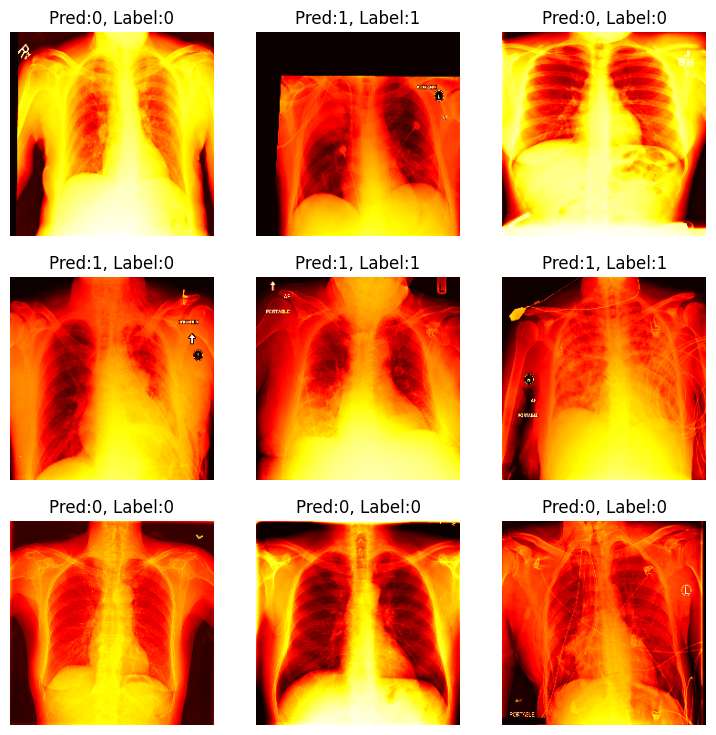

In [ ]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))
for i, j in itertools.product(range(3), range(3)):
        rnd_idx = np.random.randint(0, len(preds))
        axis[i][j].imshow(val_dataset[rnd_idx][0][0], cmap="hot")
        axis[i][j].set_title(f"Pred:{int(preds[rnd_idx] > 0.5)}, Label:{labels[rnd_idx]}")
        axis[i][j].axis("off")

# Interpretability

## Use Class Activation Maps (CAM)

In [32]:
def load_file(file_path):
    return np.load(file_path).astype(np.float32)

In [ ]:
# Transformations for the validation dataset
val_transforms = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean=0.085, std=0.234)
])

# Load the validation dataset if not loaded already
val_dataset = torchvision.datasets.DatasetFolder('../DATA/x_ray_data/Processed/val', extensions='.npy', transform=val_transforms, loader=load_file)


In [39]:
temp_model = torchvision.models.resnet18()
temp_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [40]:
# create a generator test
model_reduced=list(temp_model.children())[:-2] # removes the last two layers of the model to replace them with custom layers for the CAM

torch.nn.Sequential(*model_reduced) # makes custom model 

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [43]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1, bias=True)

        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2]) # Extract the feature map from the model of shape 7x7x512

    def forward(self, data):
        feature_map = self.feature_map(data)
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(feature_map, (1, 1)) # Compress 7x7x512 to 1x1x512 by taking the average along the last axis
        avg_output_flatteened = torch.flatten(avg_pool_output) # Flatten the output
        pred = self.model.fc(avg_output_flatteened) # Pass the output through the last layer
        return pred, feature_map

In [50]:
# create an instance of the model
model = PneumoniaModel.load_from_checkpoint('../DATA/x_ray_data/Processed/lightning_logs/version_6/checkpoints/epoch=34-step=13125.ckpt', strict=False)
model.eval() # Set the model to evaluation mode
model.to('cpu')


f:\coding_projects\udemy_deep_learning_with_pytorch_medical_image_analysis\torchcuda_env\lib\site-packages\pytorch_lightning\core\saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['feature_map.0.weight', 'feature_map.1.weight', 'feature_map.1.bias', 'feature_map.1.running_mean', 'feature_map.1.running_var', 'feature_map.4.0.conv1.weight', 'feature_map.4.0.bn1.weight', 'feature_map.4.0.bn1.bias', 'feature_map.4.0.bn1.running_mean', 'feature_map.4.0.bn1.running_var', 'feature_map.4.0.conv2.weight', 'feature_map.4.0.bn2.weight', 'feature_map.4.0.bn2.bias', 'feature_map.4.0.bn2.running_mean', 'feature_map.4.0.bn2.running_var', 'feature_map.4.1.conv1.weight', 'feature_map.4.1.bn1.weight', 'feature_map.4.1.bn1.bias', 'feature_map.4.1.bn1.running_mean', 'feature_map.4.1.bn1.running_var', 'feature_map.4.1.conv2.weight', 'feature_map.4.1.bn2.weight', 'feature_map.4.1.bn2.bias', 'feature_map.4.1.bn2.running_mean', 'feature_map.4.1.bn2.running_var', 'feature_m

PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [51]:
# Make CAM function
def cam(model, img):
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0)) # feature shape is 512x7x7
    features = features.reshape(512, 49)
    weight_params = list(model.model.fc.parameters())[0]
    weight = weight_params[0].detach()

    cam = torch.matmul(weight, features)
    cam_img = cam.reshape(7,7).cpu()
    return cam_img, torch.sigmoid(pred) # convert to a probablity

In [78]:
def visualize(img, cam, pred):
    img =img[0]
    cam = transforms.functional.resize(cam.unsqueeze(0), (224, 224))[0]

    fig, axis = plt.subplots(1,2)
    axis[0].imshow(img, cmap="bone")
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(cam, alpha=0.5, cmap="jet")
    axis[1].set_title(pred > 0.5)

In [79]:
img = val_dataset[500][0]
activation_map, pred = cam(model, img)

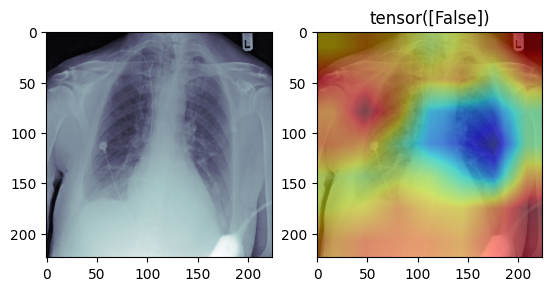

In [80]:
visualize(img, activation_map, pred)

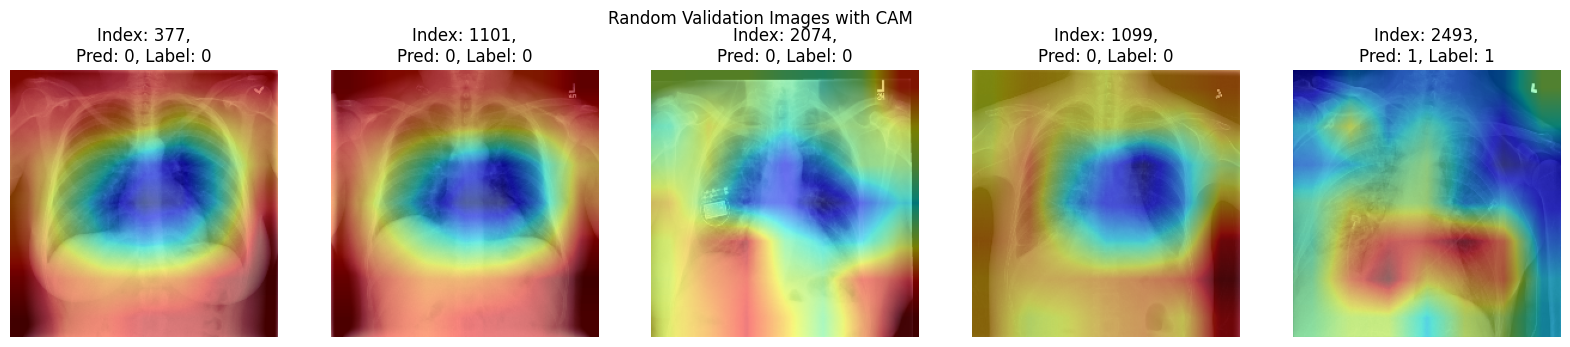

: 

In [ ]:
fig, axis = plt.subplots(1, 5, figsize=(20, 4))
plt.suptitle('Random Validation Images with CAM')

for ax in axis:
    random_index = np.random.randint(0, len(val_dataset))
    img, label = val_dataset[random_index]
    activation_map, pred = cam(model, img)
    img = img[0]
    cam_resized = transforms.functional.resize(activation_map.unsqueeze(0), (224, 224))[0]

    ax.imshow(img, cmap="bone")
    ax.imshow(cam_resized, alpha=0.5, cmap="jet")
    ax.set_title(f'Index: {random_index},\nPred: {int(pred > 0.5)}, Label: {label}')
    ax.axis("off")

plt.savefig('F:/coding_projects/udemy_deep_learning_with_pytorch_medical_image_analysis/xray_pneumonia_classification/Visualizations/CAM_random_xray_classification.jpeg', dpi=300)

plt.show()

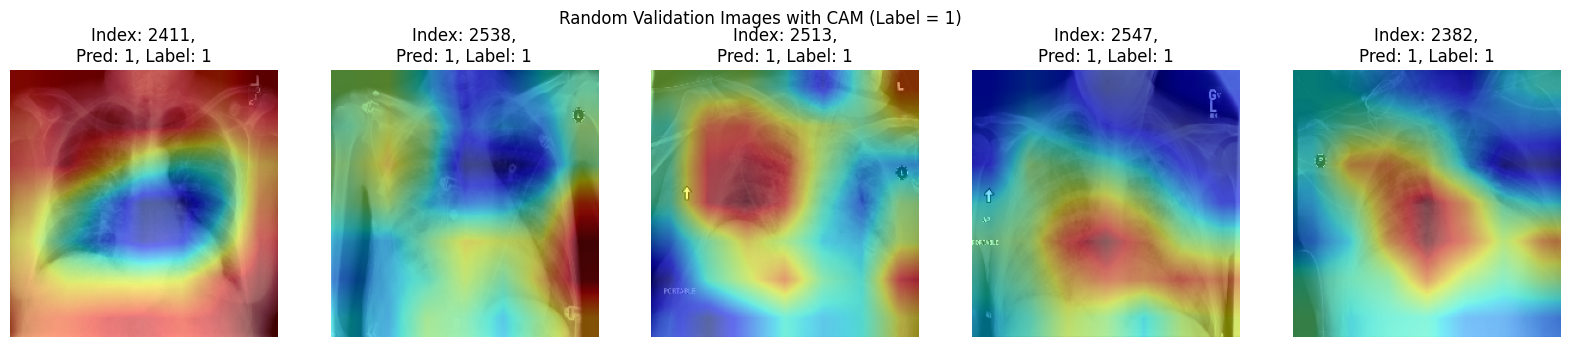

In [104]:
fig, axis = plt.subplots(1, 5, figsize=(20, 4))
plt.suptitle('Random Validation Images with CAM (Label = 1)')

count = 0
while count < 5:
    random_index = np.random.randint(0, len(val_dataset))
    img, label = val_dataset[random_index]
    activation_map, pred = cam(model, img)
    if label > 0.5:  # Select only images where the prediction is 1
        img = img[0]
        cam_resized = transforms.functional.resize(activation_map.unsqueeze(0), (224, 224))[0]

        axis[count].imshow(img, cmap="bone")
        axis[count].imshow(cam_resized, alpha=0.5, cmap="jet")
        axis[count].set_title(f'Index: {random_index},\nPred: 1, Label: {label}')
        axis[count].axis("off")
        count += 1
plt.savefig('F:/coding_projects/udemy_deep_learning_with_pytorch_medical_image_analysis/xray_pneumonia_classification/Visualizations/CAM_random_label_1_xray_classification.jpeg', dpi=300)
plt.show()

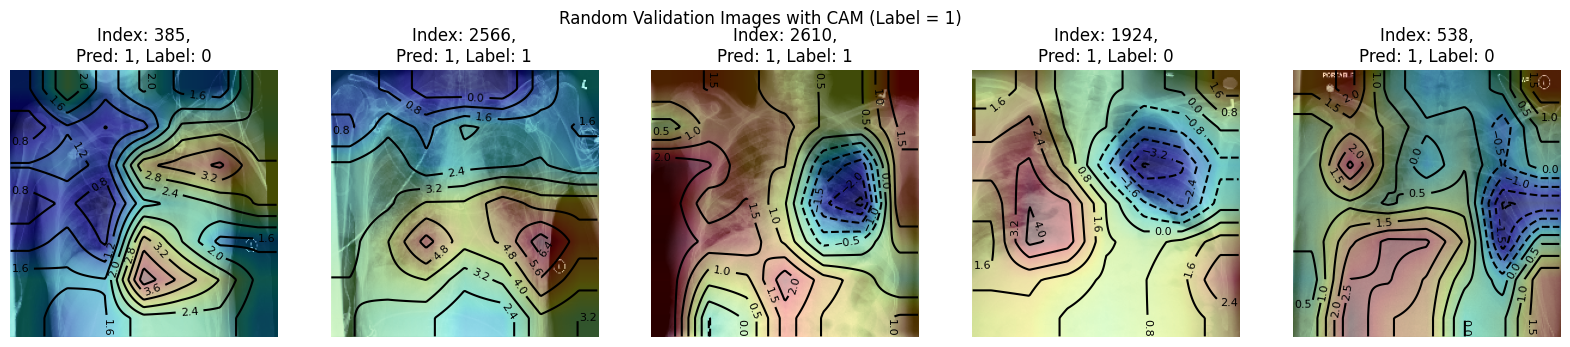

In [103]:
fig, axis = plt.subplots(1, 5, figsize=(20, 4))
plt.suptitle('Random Validation Images with CAM (Label = 1)')

count = 0
while count < 5:
    random_index = np.random.randint(0, len(val_dataset))
    img, label = val_dataset[random_index]
    activation_map, pred = cam(model, img)
    if pred > 0.5:  # Select only images where the prediction is 1
        img = img[0]
        cam_resized = transforms.functional.resize(activation_map.unsqueeze(0), (224, 224))[0]

        axis[count].imshow(img, cmap="bone")
        axis[count].imshow(cam_resized, alpha=0.3, cmap="jet")
        contour = axis[count].contour(cam_resized, levels=10, colors='black')
        axis[count].clabel(contour, inline=True, fontsize=8)
        axis[count].set_title(f'Index: {random_index},\nPred: 1, Label: {label}')
        axis[count].axis("off")
        count += 1

plt.savefig('F:/coding_projects/udemy_deep_learning_with_pytorch_medical_image_analysis/xray_pneumonia_classification/Visualizations/CAM_contours_random_pred_1_xray_classification.jpeg', dpi=300)
plt.show()